In [ ]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob

In [ ]:
#load and check data
ds=xr.open_dataset("C:/Users/Megan Jeffers/Documents/EAC_Nuts_Paper/data/EAC_filled-daily-distance-depth-gridded-product_20120401-20220727.nc")
ds

In [113]:
ds

<xarray.Dataset>
Dimensions:    (TIME: 3770, DEPTH: 251, LONGITUDE: 124)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2012-04-01T12:00:00 ... 2022-07-27T12:00:00
  * DEPTH      (DEPTH) float64 0.0 20.0 40.0 60.0 ... 4.96e+03 4.98e+03 5e+03
  * LONGITUDE  (LONGITUDE) float64 153.6 153.6 153.6 153.6 ... 155.3 155.3 155.3
    LATITUDE   (LONGITUDE) float64 ...
Data variables:
    TEMP       (TIME, DEPTH, LONGITUDE) float64 ...
    PSAL       (TIME, DEPTH, LONGITUDE) float64 ...
    UCUR       (TIME, DEPTH, LONGITUDE) float64 0.037 0.036 0.034 ... nan nan
    VCUR       (TIME, DEPTH, LONGITUDE) float64 -0.143 -0.142 -0.141 ... nan nan
Attributes: (12/38)
    project:                       Integrated Marine Observing System (IMOS),...
    Conventions:                   CF-1.6,IMOS-1.4
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         East Australian Current gridded (depth, di...
    date_created:                  2023-02-15T10:43:02Z
    date_modified:                 2023-02-15T10:43:02Z
    ...                            ...
    citation:                      The citation in a list of references is: "...
    persistent_URL:                https://hdl.handle.net/102.100.100/434305
    acknowledgement:               This project is supported with funding fro...
    disclaimer:                    Data, products and services from CSIRO are...
    license:                       http://creativecommons.org/licenses/by/4.0/
    comment:                       Data from the IMOS North Stradbroke Island...

Calculate volume trasnport and heat transport

Repeat calculations but using only VCUR since transect is only longitude

In [97]:
#volume trasnport calculate (chap gpt code)
#integral of velocity over area
# Extract V velocity components
v_velocity = ds['VCUR']  

# Calculate horizontal velocity magnitudes


# Define the depth coordinate and transect slice
depth = ds['DEPTH'].isel(DEPTH=slice(0,101)) #0-2000m
transect_slice = slice(0, 123)  # Define your transect slice

# Initialize an empty array to store volume transport for each time step
volume_transport_list = list()

# Iterate over time steps
for time_step in range(0,3770,1):
    
    # Calculate the transport along the transect for the current time step
    transport = v_velocity.isel(LONGITUDE=transect_slice, TIME=time_step).sum(dim='LONGITUDE')
    
    # Convert transport to volume transport (if depth is in meters)
    volume_transport = transport * depth
    
    # Append the result to the array
    volume_transport_list.append(volume_transport)
    

# Combine the results into a new xarray dataset along the time dimension
volume_transport_ds = xr.concat(volume_transport_list, dim='TIME')

#has dim for depth so possibly do this
volume_transport_per_day=volume_transport_ds.sum(dim='DEPTH')

# Optionally, you can save the results to a new NetCDF file
#volume_transport_ds.to_netcdf('volume_transport_time_series.nc')

[Text(0.5, 1.0, 'Volume Transport above 2000m'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Transport ')]

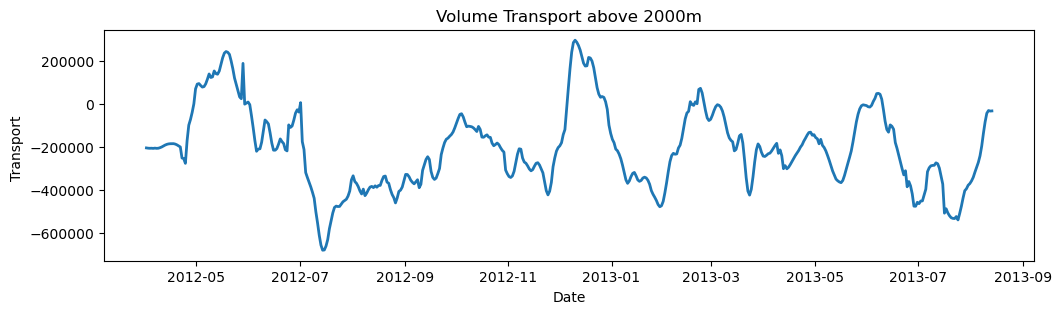

In [117]:
#plot time series for 2012/2013 for volume transport
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(volume_transport_per_day.isel(TIME=slice(0,500)).TIME, volume_transport_per_day.isel(TIME=slice(0,500)).values,linewidth=2)
ax.set(title = "Volume Transport above 2000m",
       xlabel = "Date",
       ylabel = "Transport ")

In [118]:
#heat trasnport calculate
#integral of heat times velocity over the area
# Extract temperature, VCUR, and depth
temperature = ds['TEMP']  # Replace with the actual variable name
vcur = ds['VCUR']  # Replace with the actual variable name
depth = ds['DEPTH'].isel(DEPTH=slice(0,101))  # Replace with the actual depth coordinate name

# Define constants
density = 1025.0  # Example value for seawater density in kg/m³
specific_heat_capacity = 3850.0  # Example value for specific heat capacity in J/(kg·K)

# Calculate the area element based on grid spacing in x and y directions
# Assuming uniform grid spacing
dx = ds['LONGITUDE'].diff('LONGITUDE').mean().values  # Grid spacing in longitude
dy = depth.diff('DEPTH').mean().values  # Grid spacing in depth
area_element = dx * dy

# Initialize an empty list to store daily heat flux DataArrays
daily_heat_flux_list = []

# Iterate over time steps (days)
for time_step in range(0,3770,1):
    # Extract temperature, VCUR, and depth for the current day
    temperature_day = temperature.isel(TIME=time_step)
    vcur_day = vcur.isel(TIME=time_step)
    
    # Calculate the heat flux at each (longitude, depth) point for the current day
    heat_flux_day = specific_heat_capacity * temperature_day * vcur_day * area_element
    
    # Integrate the heat flux along the z-direction (depth) for the current day
    total_heat_flux_day = heat_flux_day.sum(dim=['DEPTH','LONGITUDE'])
    
    # Append the result as a DataArray to the list
    daily_heat_flux_list.append(total_heat_flux_day)

# Concatenate the DataArrays along the time dimension to get daily heat flux
daily_heat_flux_ds = xr.concat(daily_heat_flux_list, dim='TIME')


[Text(0.5, 1.0, 'Heat Flux above 2000m'),
 Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Flux (PW)')]

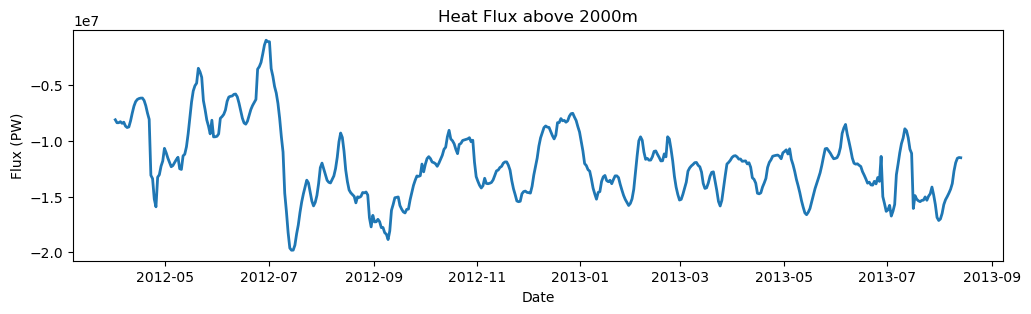

In [119]:
#plot time series for 2012/2013 for heat flux
fig, ax=plt.subplots(figsize=(12, 3))

ax.plot(daily_heat_flux_ds.isel(TIME=slice(0,500)).TIME, daily_heat_flux_ds.isel(TIME=slice(0,500)).values,linewidth=2)
ax.set(title = "Heat Flux above 2000m",
       xlabel = "Date",
       ylabel = "Flux (PW)")